In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from pathlib import Path

from rasterstats import zonal_stats
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob, os
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

/home/alal/anaconda3/envs/gds/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from joblib import Parallel, delayed
import functools

### Folder Structure

In [3]:
#%% Read in data
rice_root = '/home/apoorval/Research/GeoSpatial/India_Forests/'
dbox_root = '/home/alal/res/india_pesa_forests/'
root = Path(dbox_root)
data = root / 'inp'
spatial = data/'spatial'

# Polygon prep

In [ ]:
%%time
vil_treat = gpd.read_parquet(spatial/"Village_stack_treatment.spq")
vil_treat.head()

In [ ]:
%%time
vil_mcols = vil_treat[['STATE_UT', 'CODE_2011', 'geometry']].dissolve(by="CODE_2011")

In [ ]:
vil_mcols.groupby(['CODE_2011']).size().value_counts()
vil_mcols.set_index("CODE_2011", inplace = True)
vil_mcols.to_parquet(root/"tmp/vil_to_merge.spq")

# Dry Run

In [4]:
vil_mcols = gpd.read_parquet(root/"tmp/vil_to_merge.spq")

In [41]:
vcf_rasters = glob.glob(str(root/"inp/**/*.tif"), recursive = True)
vcf_rasters[:5]

['/home/alal/res/india_pesa_forests/inp/VCF_Rasters/VCF5KYR_1982001_001_2018224204211.tif',
 '/home/alal/res/india_pesa_forests/inp/VCF_Rasters/VCF5KYR_2001001_001_2018224205557.tif',
 '/home/alal/res/india_pesa_forests/inp/VCF_Rasters/VCF5KYR_1984001_001_2018224204542.tif',
 '/home/alal/res/india_pesa_forests/inp/VCF_Rasters/VCF5KYR_1988001_001_2018224204838.tif',
 '/home/alal/res/india_pesa_forests/inp/VCF_Rasters/VCF5KYR_2015001_001_2018224210248.tif']

In [42]:
rast = rasterio.open(vcf_rasters[0])

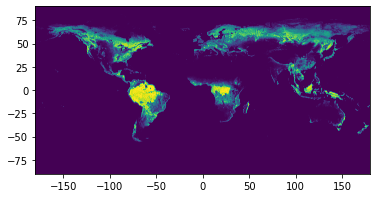

<AxesSubplot:>

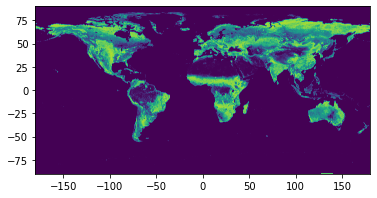

<AxesSubplot:>

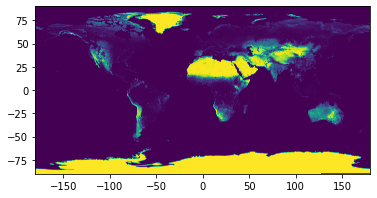

<AxesSubplot:>

In [43]:
show((rast, 1), cmap = "viridis")
show((rast, 2), cmap = "viridis")
show((rast, 3), cmap = "viridis")

## reproject village data before zonal stats

In [8]:
%%time
vil_reprojected = vil_mcols.to_crs(rast.crs.data)
vil_reprojected.crs

CPU times: user 3.43 s, sys: 503 ms, total: 3.94 s
Wall time: 3.94 s


<Geographic 2D CRS: +proj=longlat +ellps=clrk66 +no_defs +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on Clarke 1866 ellipsoid
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

## zonal stats func

In [9]:
def vil_zonal_stats(fp, polygons = vil_reprojected,
                    stat = ['min', 'max', 'mean', 'median', 'majority']):
    name = fp.split("/")[-1].split(".")[0][8:12]
    rast = rasterio.open(fp)
    array = rast.read(1)
    # Get the affine
    affine = rast.transform
    gdf1 = gpd.GeoDataFrame.from_features(
                zonal_stats(polygons, array, affine=affine,
                geojson_out = True, nodata = -1, stats = stat)
            )
    gdf1.index = vil_mcols.index
    remaps = dict(zip(stat, [s + "_" + name for s in stat]))
    gdf1.rename(remaps, axis = 1, inplace = True)
    gdf1.drop("geometry", axis = 1, inplace = True)
    return gdf1
# %%

In [10]:
%%time
df = vil_zonal_stats(vcf_rasters[0])
# df.head()

CPU times: user 5min 51s, sys: 6.18 s, total: 5min 57s
Wall time: 5min 57s


In [11]:
df.mean_1982.describe()
df.mean_1982.isna().value_counts()

count    52857.000000
mean         3.166538
std          5.275302
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max         77.000000
Name: mean_1982, dtype: float64

True     251932
False     52857
Name: mean_1982, dtype: int64

## Raster Merge 

In [ ]:
%%time
list_cov_gdf = Parallel(n_jobs=3)(delayed(vil_zonal_stats)(f) for f in vcf_rasters)

In [14]:
%%time
forest_cols = functools.reduce(lambda x, y: pd.merge(x, y,
        left_index = True, right_index = True),
    list_cov_gdf)

CPU times: user 3.76 s, sys: 128 ms, total: 3.89 s
Wall time: 3.9 s


In [16]:
forest_cols.info(max_cols = 200)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 304789 entries, 0202300083006673 to 3463405908804035
Data columns (total 192 columns):
 #    Column         Non-Null Count   Dtype  
---   ------         --------------   -----  
 0    STATE_UT_x     304789 non-null  object 
 1    min_1982       52857 non-null   float64
 2    max_1982       52857 non-null   float64
 3    mean_1982      52857 non-null   float64
 4    median_1982    52857 non-null   float64
 5    majority_1982  52857 non-null   float64
 6    STATE_UT_y     304789 non-null  object 
 7    min_2001       52857 non-null   float64
 8    max_2001       52857 non-null   float64
 9    mean_2001      52857 non-null   float64
 10   median_2001    52857 non-null   float64
 11   majority_2001  52857 non-null   float64
 12   STATE_UT_x     304789 non-null  object 
 13   min_1984       52857 non-null   float64
 14   max_1984       52857 non-null   float64
 15   mean_1984      52857 non-null   float64
 16   median_1984    52857 non-n

In [17]:
forest_cols.drop(["STATE_UT_x", "STATE_UT_y"], axis = 1, inplace = True)

In [18]:
forest_cols.to_csv(root/"tmp/forest_long_time_series.csv")

## plot

In [64]:
import georasters as gr
from shapely.geometry import box

In [19]:
vil_w_forest = vil_reprojected.merge(forest_cols, left_index = True, right_index = True)
vil_w_forest.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 304789 entries, 0202300083006673 to 3463405908804035
Columns: 162 entries, geometry to majority_2011
dtypes: float64(160), geometry(1), object(1)
memory usage: 387.1+ MB


In [27]:
%%time
vil_w_forest = vil_w_forest.to_crs("epsg:4326")

In [57]:
vil_w_forest['mean_2001'] = vil_w_forest['mean_2001'].fillna(0)
jh = vil_w_forest.query("STATE_UT == 'Jharkhand'")

In [52]:
inpath = root/'inp/VCF_Rasters/VCF5KYR_2001001_001_2018224205557.tif'
rast = rasterio.open(str(inpath))

In [60]:
%%time
outline = jh.dissolve(by = "STATE_UT")

CPU times: user 1min 29s, sys: 53.5 ms, total: 1min 29s
Wall time: 1min 29s


In [61]:
bbox = box(outline.bounds)

,minx,miny,maxx,maxy
STATE_UT,,,,
Jharkhand,83.3319,21.9699,87.91917,25.34845


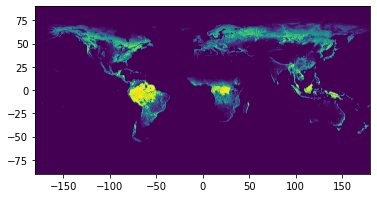

<AxesSubplot:>

In [54]:
show((rast, 1), cmap='viridis')

In [ ]:

f, ax = plt.subplots(1, 2, figsize = (10, 12), dpi = 120)
# polygon outline
# categorical polygon
jh.plot(column = 'mean_2001', 
                cmap = 'viridis', edgecolor = None, ax = ax[0]
             )
# title
ax[0].set_title("Forest Cover (VCF)\n Jharkhand, 2001")
# set axes off
ax[0].set_axis_off()



f.savefig(root/'tmp/jhar_map.pdf')